# PU learning techniques applied to artificial data

## "Circles" data set

In [21]:
import pandas as pd                    # for data handling
import numpy as np                     # for random selections, mainly
import matplotlib.pyplot as plt        # for plotting
%matplotlib inline                  
plt.rcParams['figure.figsize'] = 7,7   # graph dimensions
plt.rcParams['font.size'] = 14         # graph font size

In [22]:
# Create the data set
from sklearn.datasets import make_circles
X, y = make_circles(
    n_samples = 6000, noise = 0.1, 
    shuffle = True, factor = .65
)
X = pd.DataFrame(X, columns = ['feature1', 'feature2'])
y = pd.Series(y)

In [23]:
# Check the contents of the set
print('%d data points and %d features' % (X.shape))
print('%d positive out of %d total' % (sum(y), len(y)))

6000 data points and 2 features
3000 positive out of 6000 total


In [24]:
# Keep the original targets safe for later
y_orig = y.copy()

# Unlabel a certain number of data points
hidden_size = 2700
y.loc[
    np.random.choice(
        y[y == 1].index, 
        replace = False, 
        size = hidden_size
    )
] = 0

In [5]:
# Check the new contents of the set
print('%d positive out of %d total' % (sum(y), len(y)))

300 positive out of 6000 total


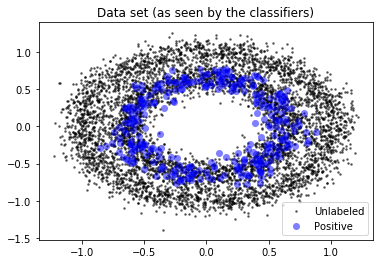

In [6]:
# Plot the data set, as the models will see it
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c='k', marker='.', linewidth=1, s=10, alpha=0.5, 
    label='Unlabeled'
)
plt.scatter(
    X[y==1].feature1, X[y==1].feature2, 
    c='b', marker='o', linewidth=0, s=50, alpha=0.5, 
    label='Positive'
)
plt.legend()
plt.title('Data set (as seen by the classifiers)')
plt.show()

## Standard classifier

In [7]:
# We'll use a generic random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(
    n_estimators = 1000,  # Use 1000 trees
    n_jobs = -1           # Use all CPU cores
)
rf.fit(X, y)

# Store the scores assigned by this approach
results = pd.DataFrame({
    'truth'      : y_orig,   # The true labels
    'label'      : y,        # The labels to be shown to models in experiment
    'output_std' : rf.predict_proba(X)[:,1]   # The random forest's scores
}, columns = ['truth', 'label', 'output_std'])

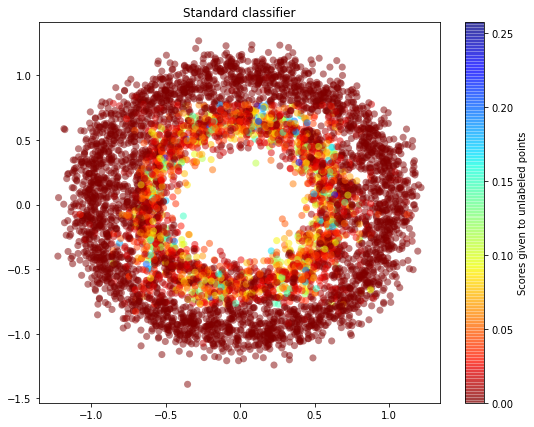

In [8]:
# Visualize this approach's results
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_std, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Standard classifier')
plt.show()

## Bagging
### The long way

In [9]:
# Use 1000 trees
from sklearn.tree import DecisionTreeClassifier
n_estimators = 1000
estimator = DecisionTreeClassifier()

# Keep track of the indices of positive and unlabeled data points
iP = y[y > 0].index
iU = y[y <= 0].index

# For each data point, keep track of how many times it has been OOB...
num_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)

# ...and the sum of its OOB scores
sum_oob = pd.DataFrame(np.zeros(shape = y.shape), index = y.index)

for _ in range(n_estimators):
    # Get a bootstrap sample of unlabeled points for this round
    ib = np.random.choice(iU, replace=True, size = len(iP))

    # Find the OOB data points for this round
    i_oob = list(set(iU) - set(ib))

    # Get the training data (ALL positives and the bootstrap 
    # sample of unlabeled points) and build the tree
    Xb = X[y > 0].append(X.loc[ib])
    yb = y[y > 0].append(y.loc[ib])
    estimator.fit(Xb, yb)
    
    # Record the OOB scores from this round
    sum_oob.loc[i_oob, 0] += estimator.predict_proba(X.loc[i_oob])[:,1]
    num_oob.loc[i_oob, 0] += 1

# Finally, store the scores assigned by this approach
results['output_bag'] = sum_oob / num_oob

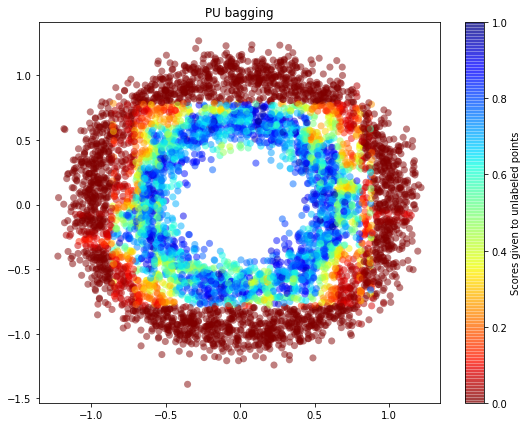

In [10]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_bag, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('PU bagging')
plt.show()

### Using `BaggingClassifierPU`

In [11]:
from baggingPU import BaggingClassifierPU
bc = BaggingClassifierPU(
    DecisionTreeClassifier(), 
    n_estimators = 1000,  # 1000 trees as usual
    max_samples = sum(y), # Balance the positives and unlabeled in each bag
    n_jobs = -1           # Use all cores
)
bc.fit(X, y)
results['output_skb'] = bc.oob_decision_function_[:,1]

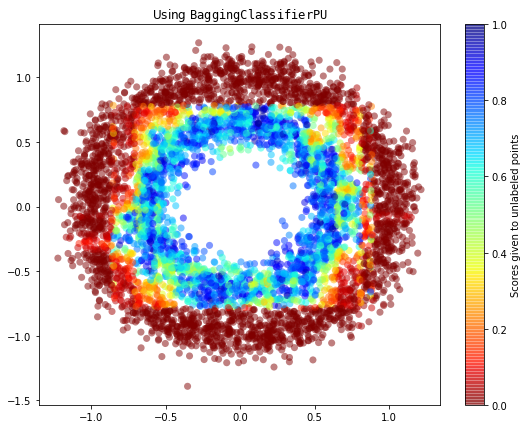

In [12]:
# Visualize this approach's results
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_skb, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title(r'Using ${\tt BaggingClassifierPU}$')
plt.show()

## Two-step

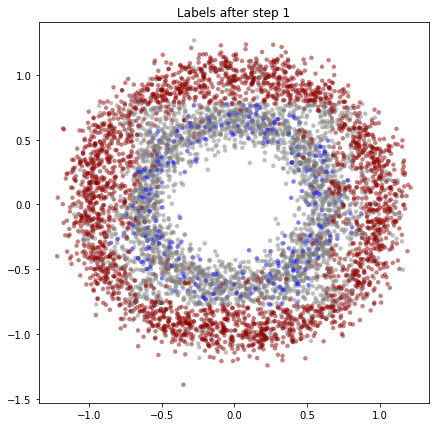

Step 1 labeled 0 new positives and 2739 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 249 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 94 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 43 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 37 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 28 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 24 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 12 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 18 new negatives.
Doing step 2... Step 1 labeled 0 new positives and 12 new negatives.
Doing step 2... 

In [13]:
# Create a new target vector, with 1 for positive, -1 for unlabeled, and 
# 0 for "reliable negative" (there are no reliable negatives to start with)
ys = 2 * y - 1

# Get the scores from before
pred = rf.predict_proba(X)[:,1]

# Find the range of scores given to positive data points
range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]

# STEP 1
# If any unlabeled point has a score above all known positives, 
# or below all known positives, label it accordingly
iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
ys.loc[iP_new] = 1
ys.loc[iN_new] = 0

# Show the results of step 1
plt.rcParams['figure.figsize'] = 7,7
cdict = {-1:'gray', 0:'darkred', 1:'blue'}
plt.scatter(
    X.feature1, X.feature2, 
    c = [cdict[k] for k in ys], 
    linewidth = 0, s = 20, alpha = 0.5
)
plt.title('Labels after step 1')
plt.show()   

# Classifier to be used for step 2
rf2 = RandomForestClassifier(n_estimators = 1000, n_jobs = -1)

# Limit to 10 iterations (this is arbitrary, but 
# otherwise this approach can take a very long time)
for i in range(10):
    # If step 1 didn't find new labels, we're done
    if len(iP_new) + len(iN_new) == 0 and i > 0:
        break
    
    print(
        'Step 1 labeled %d new positives and %d new negatives.' 
        % (len(iP_new), len(iN_new))
    )
    print('Doing step 2... ', end = '')
    
    # STEP 2
    # Retrain on new labels and get new scores
    rf2.fit(X, ys)
    pred = rf2.predict_proba(X)[:,-1]
    
    # Find the range of scores given to positive data points
    range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]
    
    # Repeat step 1
    iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
    iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
    ys.loc[iP_new] = 1
    ys.loc[iN_new] = 0
    
    
# Lastly, get the scores assigned by this approach    
results['output_stp'] = pred

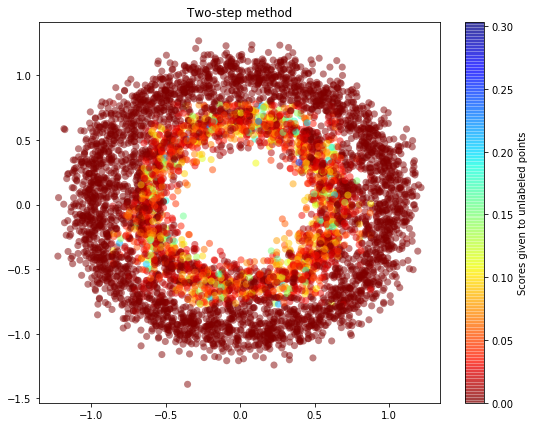

In [14]:
# Visualize this approach's final results
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_stp, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Two-step method')
plt.show()

## Comparison of approaches

In [15]:
# For each data point, calculate the average score from the three approaches
results['output_all'] = results[[
    'output_std', 'output_bag', 'output_stp'
]].mean(axis = 1)

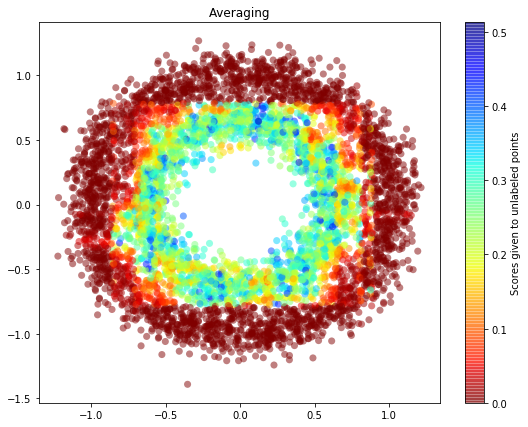

In [16]:
# Visualize average scores
plt.rcParams['figure.figsize'] = 9,7
plt.scatter(
    X[y==0].feature1, X[y==0].feature2, 
    c = results[y==0].output_all, linewidth = 0, s = 50, alpha = 0.5, 
    cmap = 'jet_r'
)
plt.colorbar(label='Scores given to unlabeled points')
plt.title('Averaging')
plt.show()

In [17]:
# Prepare for graphing the performance 
# (i.e. the success in identifying hidden positives)
ts = range(100, hidden_size, 100)
y_std, y_bag, y_skb, y_stp, y_all = [], [], [], [], []
for t in ts:
    y_std.append(
        results[results.label == 0].sort_values(
            'output_std', ascending = False
        ).head(t).truth.mean()
    )
    y_bag.append(
        results[results.label == 0].sort_values(
            'output_bag', ascending = False
        ).head(t).truth.mean()
    )
    y_skb.append(
        results[results.label == 0].sort_values(
            'output_skb', ascending = False
        ).head(t).truth.mean()
    )
    y_stp.append(
        results[results.label == 0].sort_values(
            'output_stp', ascending = False
        ).head(t).truth.mean()
    )
    y_all.append(
        results[results.label == 0].sort_values(
            'output_all', ascending = False
        ).head(t).truth.mean()
    )
    

In [18]:
# Check the difference between PU bagging the 
# long way and using BaggingClassifierPU
[y_bag[i] - y_skb[i] for i in range(len(y_bag))]

[0.0,
 0.0,
 -0.00666666666666671,
 -0.0025000000000000577,
 -0.0020000000000000018,
 0.0050000000000000044,
 0.0028571428571427804,
 0.00374999999999992,
 0.0,
 0.0010000000000000009,
 0.0018181818181818299,
 0.0008333333333332416,
 -0.0007692307692308553,
 0.0007142857142856673,
 0.0006666666666665932,
 -0.0012499999999999734,
 0.0005882352941176672,
 0.0,
 0.000526315789473708,
 0.000500000000000056,
 0.0,
 0.0013636363636363447,
 0.0008695652173913437,
 0.0008333333333332416,
 0.0012000000000000899,
 0.0007692307692307443]

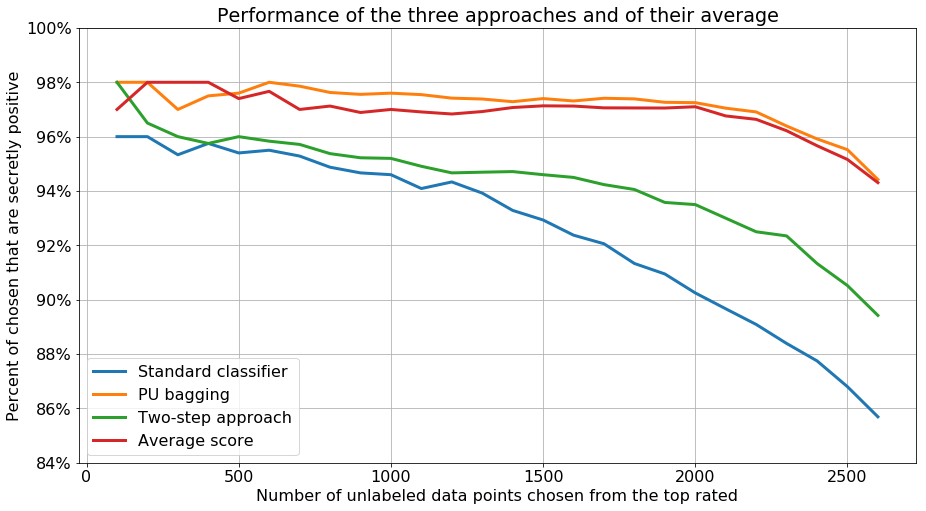

In [19]:
# Performance graphing
plt.rcParams['font.size'] = 16
plt.rcParams['figure.figsize'] = 15, 8

plt.plot(
    ts, y_std,
    ts, y_bag,
    ts, y_stp,
    ts, y_all,
    lw = 3
)

vals = plt.gca().get_yticks()
plt.yticks(vals, ['%.0f%%' % (v*100) for v in vals])
plt.xlabel('Number of unlabeled data points chosen from the top rated')
plt.ylabel('Percent of chosen that are secretly positive')
plt.legend([
    'Standard classifier', 
    'PU bagging', 
    'Two-step approach', 
    'Average score'
])
ylim = plt.gca().get_ylim()
plt.title('Performance of the three approaches and of their average')
plt.grid()
plt.show()